In [154]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd

import dython

from sklearn.feature_selection import SelectFpr, chi2, SelectKBest, SelectFwe, f_classif, SelectFdr


In [155]:
relative_dir = "../data/curated/"
income = pd.read_csv("../data/raw/external/vic_income.csv", index_col=0)
mapping = pd.read_csv(relative_dir + "sa2_postcode_mapping_2021.csv")
properties = pd.read_csv(relative_dir + "categorised_distances.csv", index_col=0)

In [156]:
properties['Postcode'] = properties['Postcode'].astype(str)

In [157]:
mapping['postcode_2021'] = mapping['postcode_2021'].astype(str)

In [158]:
properties = pd.merge(properties, mapping, left_on='Postcode', right_on='postcode_2021').drop('postcode_2021', axis=1)

In [159]:
properties['sa2_2021'] = properties['sa2_2021'].astype(str)
properties = properties.rename({'sa2_2021':'SA2'})

## Income Data

In [160]:
income['SA2'] = income['SA2'].astype(str)
income.head()

,SA2,SA2_name,Earners,Median_age,Sum,Median
579,201011001,Alfredton,7989,42,508645842,53932
580,201011002,Ballarat,7595,47,591465895,53688
581,201011003,Ballarat - North,13598,43,820866354,50593
582,201011004,Ballarat - South,12722,40,646001740,45828
583,201011005,Buninyong,4249,46,268782250,52377


In [161]:
properties['sa2_2021'] = properties['sa2_2021'].astype(float).astype(int).astype(str)
properties = pd.merge(properties, income, left_on='sa2_2021', right_on='SA2')
properties.head(1)

,Name,Cost,Coordinates,Bed,Bath,Parking,Property_Type,Agency,Postcode,cbd_duration,...,postoffice_distance,primary_distance,secondary_distance,sa2_2021,SA2,SA2_name,Earners,Median_age,Sum,Median
0,5408/500 Elizabeth Street Melbourne VIC 3000,440.0,"[-37.8072443, 144.9602814]",1,1,0,Apartment / Unit / Flat,BRADY residential,3000,80.0,...,1,1,1,206041117,206041117,Carlton,9422,30,563346766,38891


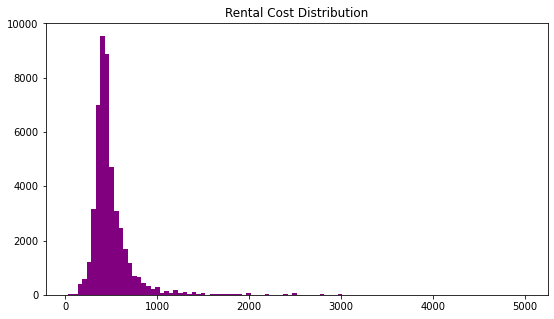

In [162]:
# Rental Cost Distribution
plt.figure(figsize = (9, 5))
plt.title('Rental Cost Distribution')
plt.hist(properties['Cost'], bins=100, color='purple')
plt.savefig('../plots/cost_distribution.jpg')
plt.show()

## Continuous Data Correlations
*Note:* We treat the ordinal features as continuous in order to keep ordering information.

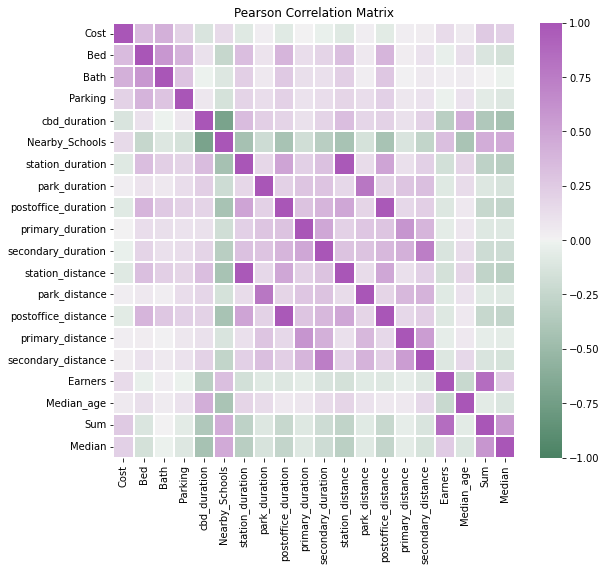

In [163]:
corrmat = properties.corr(method='pearson')
f, ax = plt.subplots(figsize =(9, 8))
colours = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# possible colours: "coolwarm", "vlag"
sns.heatmap(corrmat, ax = ax, cmap=colours, linewidths = 0.1, center=0, vmin=-1)
plt.title('Pearson Correlation Matrix')
plt.savefig('../plots/correlation.jpg')
plt.show()

Find the most correlated features with rental cost of property.

In [164]:
sorted_mat = corrmat.unstack().sort_values()

# reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:'correlation'}, axis=1, inplace=True)
df['Index'] = df.index
df = pd.concat(
        [df.drop('Index', axis=1), 
        df['Index'].apply(pd.Series)]
    , axis=1)

# output correlation list
cost_correlations = pd.DataFrame(df[df[0] == 'Cost']['correlation'])
cost_correlations['abs_corr'] = abs(cost_correlations['correlation'])
cost_correlations.sort_values(by='abs_corr', ascending=False)

correlation  abs_corr
Cost Cost                    1.000000  1.000000
     Bath                    0.417956  0.417956
     Bed                     0.350487  0.350487
     Sum                     0.252288  0.252288
     Median                  0.211445  0.211445
     Parking                 0.196904  0.196904
     Nearby_Schools          0.156157  0.156157
     Earners                 0.142586  0.142586
     cbd_duration           -0.126421  0.126421
     station_duration       -0.088071  0.088071
     station_distance       -0.086109  0.086109
     postoffice_duration    -0.078370  0.078370
     postoffice_distance    -0.070462  0.070462
     Median_age              0.049349  0.049349
     secondary_distance      0.035898  0.035898
     park_distance           0.031051  0.031051
     park_duration           0.027210  0.027210
     primary_distance        0.026222  0.026222
     secondary_duration     -0.023590  0.023590
     primary_duration        0.004869  0.004869

## Continuous and Categorical Data Correlations

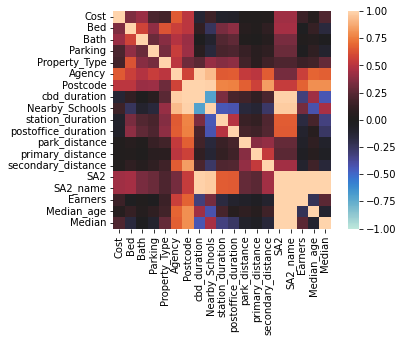

In [165]:
# get correlation of numeric attributes with cost
exclusions = ['Name', 'Coordinates', 'sa2_2021', 'Sum', 'postoffice_distance', 'station_distance', 'park_duration', 'secondary_duration', 'primary_duration']
corr_data = properties.drop(exclusions, axis=1)
corr_mat = dython.nominal.associations(corr_data, annot=False)

In [166]:
sorted_mat = corr_mat['corr'].unstack().sort_values()

# reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:'correlation'}, axis=1, inplace=True)
df['Index'] = df.index
df = pd.concat(
        [df.drop('Index', axis=1), 
        df['Index'].apply(pd.Series)]
    , axis=1)

# output correlation list
cost_correlations = pd.DataFrame(df[df[0] == 'Cost']['correlation'])
cost_correlations['abs_corr'] = abs(cost_correlations['correlation'])
cost_correlations = cost_correlations.sort_values(by='abs_corr', ascending=False)

# remove multi-level indexing
cost_correlations.index = cost_correlations.index.droplevel(0)

cost_correlations.drop('Cost')

,correlation,abs_corr
Agency,0.650220,0.650220
Postcode,0.511940,0.511940
SA2,0.430188,0.430188
SA2_name,0.430188,0.430188
Bath,0.417956,0.417956
Bed,0.350487,0.350487
Median,0.211445,0.211445
Parking,0.196904,0.196904
Property_Type,0.176706,0.176706
Nearby_Schools,0.156157,0.156157


#### Highly correlated features to note
- Postcode and SA2 are extremely correlated, so only include postcode which has slightly higher correlation with cost. 
- all distance/duration combos - pick best from each category
- Postcode highly correlated with everything
- cbd_duration: postcode and agency
- Median and total income - only include median

#### Interesting notes
- people do not care about schools, if anything they don't want to live near schools

## Categorical ANOVAs

In [109]:
# test for relationship with categorical variables using one-way ANOVA
categoricals = ['Postcode', 'Property_Type', 'Agency']

for c in categoricals:
    model = ols('Cost ~ '+c, data = properties).fit() # Oridnary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

               df        sum_sq        mean_sq         F  PR(>F)
Postcode    374.0  2.019698e+08  540026.239923  9.126862     0.0
Residual  11465.0  6.783713e+08   59168.884891       NaN     NaN
                    df        sum_sq       mean_sq         F        PR(>F)
Property_Type      9.0  3.375730e+07  3.750811e+06  52.41311  5.539890e-94
Residual       11830.0  8.465838e+08  7.156245e+04       NaN           NaN
               df        sum_sq        mean_sq         F  PR(>F)
Agency     1335.0  3.347445e+08  250744.959848  4.827422     0.0
Residual  10504.0  5.455966e+08   51941.789567       NaN     NaN


All p values are less than 0.05 so all attributes are significant.

## Feature Selection

In [105]:
y = properties['Cost']
X = properties.drop(['Cost', 'Name', 'Coordinates', 'SA2_MAINCODE_2011', 'SA2_name', 'SA2_NAME_2011', 'SA2', 'Property_Type', 'Agency'], axis=1)

# selector = SelectKBest(score_func=chi2, k=10)
selector = SelectFwe(score_func=chi2, alpha=0.05)
new_data = selector.fit_transform(X, y)
 
mask = selector.get_support()
new_features = X.columns[mask]
new_features

ValueError: Input X contains NaN.
SelectFwe does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values